In [38]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io

In [39]:
img1 = cv2.imread("images/grain.jpg")
img = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

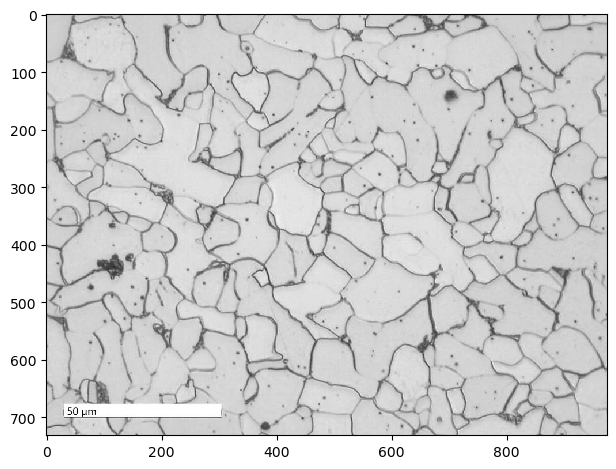

In [40]:
io.imshow(img)

In [41]:
pixels_to_um = 0.05

In [42]:
ret1, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# Morphological operations to remove small noise - opening
#To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

from skimage.segmentation import clear_border
#opening = clear_border(opening) #Remove edge touching grains


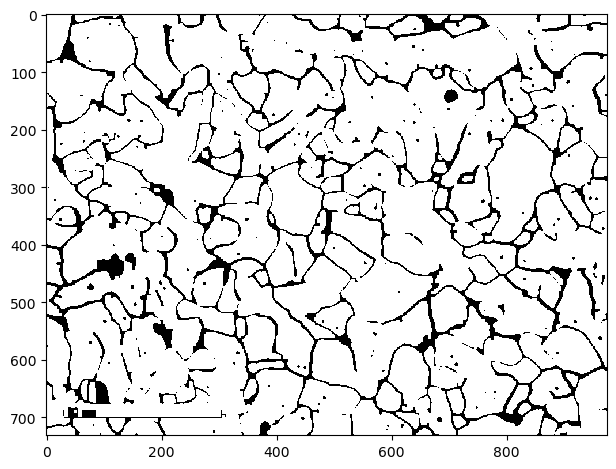

In [43]:
io.imshow(opening)

In [44]:
sure_bg = cv2.dilate(opening,kernel,iterations=2)

dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)

ret2, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)

#0.2* max value seems to separate the cells well.


# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)

unknown = cv2.subtract(sure_bg,sure_fg)


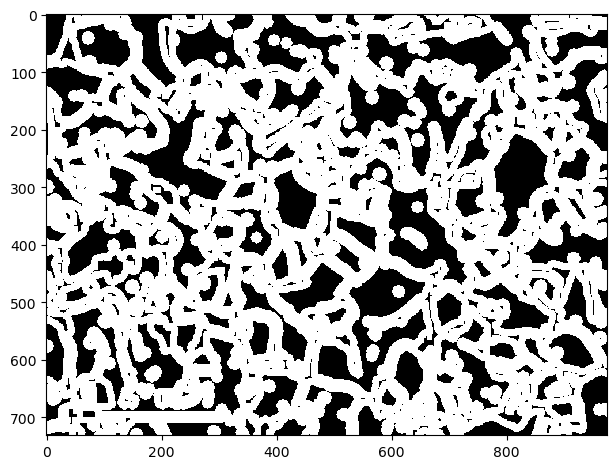

In [45]:
io.imshow(unknown)

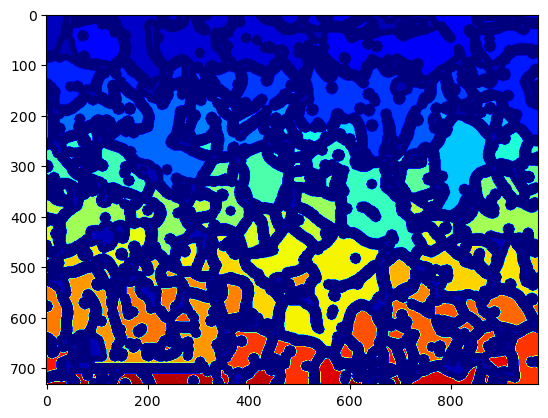

In [46]:
ret3, markers = cv2.connectedComponents(sure_fg)

#One problem rightnow is that the entire background pixels is given value 0.
#This means watershed considers this region as unknown.
#So let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.


In [47]:
#Now we are ready for watershed filling. 
markers = cv2.watershed(img1,markers)
#The boundary region will be marked -1
#Let us color boundaries in yellow. OpenCv assigns boundaries to -1 after watershed.
img1[markers == -1] = [0,255,255]  

img2 = color.label2rgb(markers, bg_label=0)

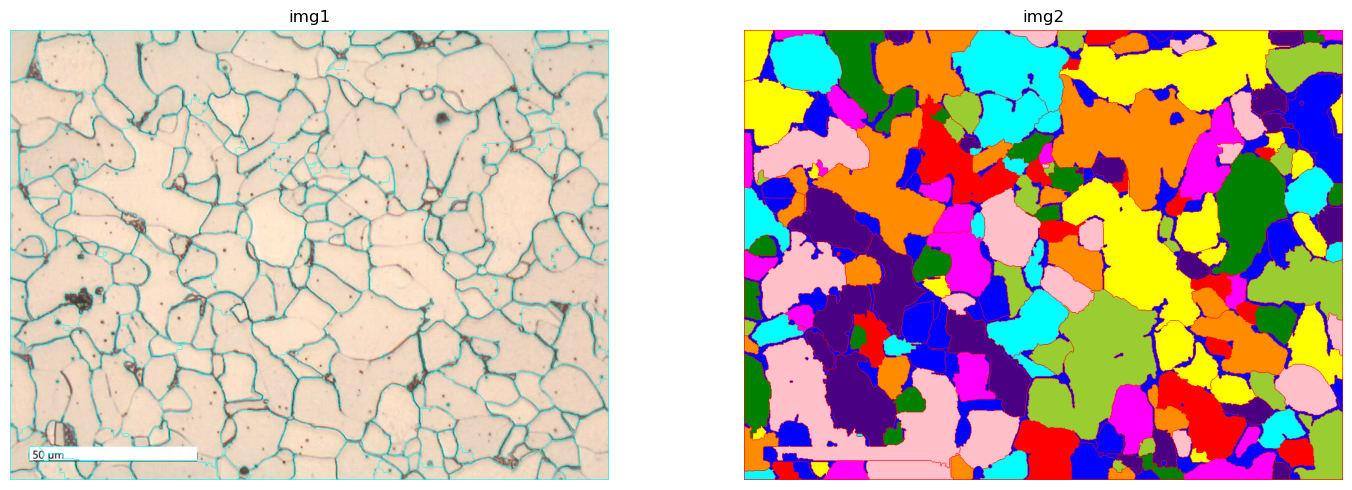

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("img1")
plt.imshow(img1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("img2")
plt.imshow(img2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [49]:
regions = measure.regionprops(markers, intensity_image=img)

propList = ['Area',
            'equivalent_diameter', 
            'orientation',
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']    
    

output_file = open('image_measurements2_watershed.csv', 'w')
output_file.write('Grain #' + "," + "," + ",".join(propList) + '\n') #join strings in array by commas, 
#First cell to print grain number
#Second cell blank as we will not print Label column

grain_number = 1
for region_props in regions:
    output_file.write(str(grain_number) + ',')
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = region_props[prop]*pixels_to_um**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = region_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = region_props[prop]*pixels_to_um
        else: 
            to_print = region_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')
    grain_number += 1
    
output_file.close()  

In [50]:
import pandas as pd 

In [51]:
df=pd.read_csv('image_measurements2_watershed.csv')
df.head(10)

,Grain #,Unnamed: 1,Area,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,Perimeter,MinIntensity,MeanIntensity,MaxIntensity
0,1,NaN,127.3500,12.733698,-82.126106,58.750277,42.451162,980.602180,0.0,137.144739,255.0
1,2,NaN,6.9425,2.973124,-11.310056,4.507725,2.109217,11.833452,150.0,202.989197,214.0
2,3,NaN,1.5850,1.420593,-86.010951,4.445030,0.598842,8.826346,123.0,201.569401,217.0
3,4,NaN,20.6325,5.125438,17.764320,8.413969,3.851854,25.682642,79.0,207.129165,228.0
4,5,NaN,1.5275,1.394587,86.167430,1.887245,1.074256,5.072792,145.0,210.250409,222.0
5,6,NaN,31.8700,6.370098,-77.596734,8.063669,5.874365,35.408126,66.0,208.391748,227.0
6,7,NaN,38.4125,6.993448,77.247482,9.747153,5.497028,36.212594,90.0,210.345265,233.0
7,8,NaN,3.1700,2.009022,82.222353,3.592540,1.346949,9.218072,168.0,210.462145,238.0
8,9,NaN,3.0650,1.975469,85.889416,2.407724,1.737095,7.774874,102.0,210.868679,226.0
9,10,NaN,3.0000,1.954410,-82.259518,3.543484,1.153631,8.804163,94.0,205.215000,235.0
